**Collecting data using ergast Api**

In [1]:
import requests
import pandas as pd
from datetime import datetime

# Base API URL
BASE_URL = "https://ergast.com/api/f1/"

# Function to fetch race results for a given season
def get_race_results(season):
    url = f"{BASE_URL}{season}/results.json?limit=1000"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        races = data["MRData"]["RaceTable"]["Races"]

        race_data = []
        for race in races:
            for result in race["Results"]:
                # Convert Fastest Lap time to seconds
                fastest_lap_time = None
                if "FastestLap" in result and "Time" in result["FastestLap"]:
                    time_str = result["FastestLap"]["Time"]["time"]  # e.g., "1:32.745"
                    mins, secs = map(float, time_str.split(":"))
                    fastest_lap_time = mins * 60 + secs  # Convert to seconds

                # Handling retirement status
                retirement_status = "Finished"
                if result["positionText"] not in ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]:
                    retirement_status = "Retired"

                # Age of the driver at the time of the race (approximation)
                birth_year = int(result["Driver"]["dateOfBirth"][:4])
                driver_age = season - birth_year

                # Extracting extra data
                pit_stops = int(result["pitStops"]) if "pitStops" in result else -1
                laps_completed = int(result["laps"]) if "laps" in result else -1
                race_duration = None  # Need external API or manual extraction
                avg_speed = None  # Needs external dataset

                # New attributes for ML
                race_data.append({
                    # Race Details
                    "Season": season,
                    "Round": int(race["round"]),
                    "Race Name": race["raceName"],
                    "Date": datetime.strptime(race["date"], "%Y-%m-%d").strftime("%Y-%m-%d"),
                    "Circuit": race["Circuit"]["circuitName"],
                    "Country": race["Circuit"]["Location"]["country"],
                    "Latitude": float(race["Circuit"]["Location"]["lat"]),
                    "Longitude": float(race["Circuit"]["Location"]["long"]),
                    "Weather Conditions": "Unknown",  # External API needed

                    # Driver Information
                    "Driver": f"{result['Driver']['givenName']} {result['Driver']['familyName']}",
                    "Driver Nationality": result["Driver"]["nationality"],
                    "Driver Age": driver_age,
                    "Driver Experience (Years)": season - birth_year if season - birth_year > 18 else 0,
                    "Driver Championship Points": float(result["points"]),
                    "Driver Wins This Season": int(result.get("wins", 0)),
                    "Driver Fastest Lap Time": fastest_lap_time,
                    "Driver Fastest Lap Rank": int(result["FastestLap"]["rank"]) if "FastestLap" in result else -1,

                    # Constructor Details
                    "Constructor": result["Constructor"]["name"],
                    "Constructor Nationality": result["Constructor"]["nationality"],
                    "Constructor Championship Wins": "Unknown",  # Requires external dataset
                    "Constructor Points This Season": "Unknown",  # Requires separate API call

                    # Race Performance
                    "Grid Position": int(result["grid"]),
                    "Race Position": int(result["position"]),
                    "Points Earned": float(result["points"]),
                    "Fastest Lap (s)": fastest_lap_time,
                    "Fastest Lap Rank": int(result["FastestLap"]["rank"]) if "FastestLap" in result else -1,
                    "Total Pit Stops": pit_stops,
                    "Race Laps Completed": laps_completed,
                    "Race Duration (mins)": race_duration,
                    "Average Speed (km/h)": avg_speed,

                    # Pit Stop Strategy
                    "Pit Stop 1 Time": None,  # Needs external dataset
                    "Pit Stop 2 Time": None,
                    "Tire Strategy": None,  # Soft, Medium, Hard (External data needed)

                    # Penalties & Incidents
                    "Warnings": 0,  # Needs incident logs
                    "Drive-Through Penalties": 0,
                    "Stop-Go Penalties": 0,
                    "Disqualified": 0,
                    "Collisions": 0,

                    # Team Performance History
                    "Last Race Position": None,  # Historical data needed
                    "Last Race Points": None,
                    "Teammate Position": None,  # Needs separate teammate mapping
                    "Teammate Points": None,

                    # Track Characteristics
                    "Track Length (km)": "Unknown",  # External dataset
                    "Track Corners": "Unknown",
                    "Track Elevation Change": "Unknown",
                    "Track Surface Type": "Unknown",  # Asphalt, concrete, etc.
                    "Rain Probability (%)": "Unknown",  # Weather API needed

                    # Retirement & Crashes
                    "Retirement Status": retirement_status,
                    "Mechanical Failure": 0,  # Needs external incident logs
                    "Engine Failure": 0,
                    "Transmission Failure": 0,
                    "Brakes Failure": 0,
                    "Suspension Failure": 0,
                    "Accidents": 0,

                    # Sponsorship & Branding
                    "Driver Main Sponsor": "Unknown",  # Needs manual input
                    "Constructor Main Sponsor": "Unknown",
                })

        return race_data
    else:
        print(f"Error fetching data for {season}: {response.status_code}")
        return []

# Fetch data for 10 years (2014–2023)
years = list(range(2014, 2024))
all_race_data = []

for year in years:
    all_race_data.extend(get_race_results(year))




**RAW DATA OBTAINED IN JSON FORMAT**

In [4]:
print(all_race_data)


[{'Season': 2014, 'Round': 1, 'Race Name': 'Australian Grand Prix', 'Date': '2014-03-16', 'Circuit': 'Albert Park Grand Prix Circuit', 'Country': 'Australia', 'Latitude': -37.8497, 'Longitude': 144.968, 'Weather Conditions': 'Unknown', 'Driver': 'Nico Rosberg', 'Driver Nationality': 'German', 'Driver Age': 29, 'Driver Experience (Years)': 29, 'Driver Championship Points': 25.0, 'Driver Wins This Season': 0, 'Driver Fastest Lap Time': 92.47800000000001, 'Driver Fastest Lap Rank': 1, 'Constructor': 'Mercedes', 'Constructor Nationality': 'German', 'Constructor Championship Wins': 'Unknown', 'Constructor Points This Season': 'Unknown', 'Grid Position': 3, 'Race Position': 1, 'Points Earned': 25.0, 'Fastest Lap (s)': 92.47800000000001, 'Fastest Lap Rank': 1, 'Total Pit Stops': -1, 'Race Laps Completed': 57, 'Race Duration (mins)': None, 'Average Speed (km/h)': None, 'Pit Stop 1 Time': None, 'Pit Stop 2 Time': None, 'Tire Strategy': None, 'Warnings': 0, 'Drive-Through Penalties': 0, 'Stop-Go

**Converted into CSV file**

In [2]:
# Convert to DataFrame and save to CSV
df = pd.DataFrame(all_race_data)

df.to_csv("F1_ML_Dataset_2014_2023.csv", index=False)

print("Data saved successfully!")

Data saved successfully!


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


In [4]:
df = pd.read_csv("F1_ML_Dataset_2014_2023.csv")

In [5]:
df.head()

,Season,Round,Race Name,Date,Circuit,Country,Latitude,Longitude,Weather Conditions,Driver,...,Rain Probability (%),Retirement Status,Mechanical Failure,Engine Failure,Transmission Failure,Brakes Failure,Suspension Failure,Accidents,Driver Main Sponsor,Constructor Main Sponsor
0,2014,1,Australian Grand Prix,2014-03-16,Albert Park Grand Prix Circuit,Australia,-37.8497,144.968,Unknown,Nico Rosberg,...,Unknown,Finished,0,0,0,0,0,0,Unknown,Unknown
1,2014,1,Australian Grand Prix,2014-03-16,Albert Park Grand Prix Circuit,Australia,-37.8497,144.968,Unknown,Kevin Magnussen,...,Unknown,Finished,0,0,0,0,0,0,Unknown,Unknown
2,2014,1,Australian Grand Prix,2014-03-16,Albert Park Grand Prix Circuit,Australia,-37.8497,144.968,Unknown,Jenson Button,...,Unknown,Finished,0,0,0,0,0,0,Unknown,Unknown
3,2014,1,Australian Grand Prix,2014-03-16,Albert Park Grand Prix Circuit,Australia,-37.8497,144.968,Unknown,Fernando Alonso,...,Unknown,Finished,0,0,0,0,0,0,Unknown,Unknown
4,2014,1,Australian Grand Prix,2014-03-16,Albert Park Grand Prix Circuit,Australia,-37.8497,144.968,Unknown,Valtteri Bottas,...,Unknown,Finished,0,0,0,0,0,0,Unknown,Unknown


In [6]:
df.dtypes

,0
Season,int64
Round,int64
Race Name,object
Date,object
Circuit,object
Country,object
Latitude,float64
Longitude,float64
Weather Conditions,object
Driver,object


In [7]:
df.shape

(1000, 56)

In [8]:
df.describe()

,Season,Round,Latitude,Longitude,Driver Age,Driver Experience (Years),Driver Championship Points,Driver Wins This Season,Driver Fastest Lap Time,Driver Fastest Lap Rank,...,Last Race Position,Last Race Points,Teammate Position,Teammate Points,Mechanical Failure,Engine Failure,Transmission Failure,Brakes Failure,Suspension Failure,Accidents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,957.000000,1000.000000,...,0.0,0.0,0.0,0.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
mean,2018.500000,2.970000,22.367946,56.781734,27.667000,27.577000,5.117000,0.0,92.055716,9.707000,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
std,2.873719,1.403948,28.419050,58.906583,5.196067,5.509485,7.253132,0.0,9.546559,6.002264,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
min,2014.000000,1.000000,-37.849700,-80.238900,18.000000,0.000000,0.000000,0.0,65.619000,-1.000000,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
25%,2016.000000,2.000000,25.958100,11.716700,24.000000,24.000000,0.000000,0.0,86.186000,5.000000,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
50%,2018.500000,3.000000,31.338900,50.510600,27.000000,27.000000,1.000000,0.0,93.338000,10.000000,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
75%,2021.000000,4.000000,41.570000,121.220000,31.000000,31.000000,10.000000,0.0,98.500000,15.000000,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
max,2023.000000,6.000000,52.078600,144.968000,42.000000,42.000000,26.000000,0.0,118.376000,22.000000,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 56 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Season                          1000 non-null   int64  
 1   Round                           1000 non-null   int64  
 2   Race Name                       1000 non-null   object 
 3   Date                            1000 non-null   object 
 4   Circuit                         1000 non-null   object 
 5   Country                         1000 non-null   object 
 6   Latitude                        1000 non-null   float64
 7   Longitude                       1000 non-null   float64
 8   Weather Conditions              1000 non-null   object 
 9   Driver                          1000 non-null   object 
 10  Driver Nationality              1000 non-null   object 
 11  Driver Age                      1000 non-null   int64  
 12  Driver Experience (Years)       100

In [10]:
nan_counts = df.isnull().sum()
zero_counts = (df == 0).sum()
empty_string_counts = (df == '').sum()

missing_values = pd.DataFrame({
    'NaN Count': nan_counts,
    'Zero Count': zero_counts,
    'Empty String Count': empty_string_counts
})

print(missing_values)

                                NaN Count  Zero Count  Empty String Count
Season                                  0           0                   0
Round                                   0           0                   0
Race Name                               0           0                   0
Date                                    0           0                   0
Circuit                                 0           0                   0
Country                                 0           0                   0
Latitude                                0           0                   0
Longitude                               0           0                   0
Weather Conditions                      0           0                   0
Driver                                  0           0                   0
Driver Nationality                      0           0                   0
Driver Age                              0           0                   0
Driver Experience (Years)             

# Handling missing values

Removing columns such as Race Duration, Average Speed, Pit Stop-1 Time, Pit Stop-2 Time, Tire Strategy, Last Race Position, Last Race Points, Teammate Position, Teammate Points, and several others, as they contain no data at all

In [11]:
df.drop(columns=['Race Duration (mins)', 'Average Speed (km/h)', 'Pit Stop 1 Time',
                 'Pit Stop 2 Time', 'Tire Strategy', 'Last Race Position',
                 'Last Race Points', 'Teammate Position', 'Teammate Points',
                 'Driver Wins This Season', 'Warnings', 'Drive-Through Penalties',
                 'Stop-Go Penalties', 'Disqualified', 'Collisions',
                 'Mechanical Failure', 'Engine Failure', 'Transmission Failure',
                 'Brakes Failure', 'Suspension Failure', 'Accidents',
                 'Weather Conditions', 'Constructor Championship Wins',
                 'Constructor Points This Season', 'Track Length (km)',
                 'Track Corners', 'Track Elevation Change', 'Track Surface Type',
                 'Rain Probability (%)', 'Driver Main Sponsor',
                 'Constructor Main Sponsor'], inplace=True, errors='ignore')

For columns such as Driver Fastest Lap Time and Fastest Lap, missing values were imputed using the mean values

In [12]:
df['Driver Fastest Lap Time'].fillna(df['Driver Fastest Lap Time'].mean(), inplace=True)
df['Fastest Lap (s)'].fillna(df['Fastest Lap (s)'].mean(), inplace=True)

<ipython-input-12-d8442c60d6e7>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Driver Fastest Lap Time'].fillna(df['Driver Fastest Lap Time'].mean(), inplace=True)
<ipython-input-12-d8442c60d6e7>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col

In [13]:
nan_counts = df.isnull().sum()
zero_counts = (df == 0).sum()
empty_string_counts = (df == '').sum()

missing_values = pd.DataFrame({
    'NaN Count': nan_counts,
    'Zero Count': zero_counts,
    'Empty String Count': empty_string_counts
})

print(missing_values)

                            NaN Count  Zero Count  Empty String Count
Season                              0           0                   0
Round                               0           0                   0
Race Name                           0           0                   0
Date                                0           0                   0
Circuit                             0           0                   0
Country                             0           0                   0
Latitude                            0           0                   0
Longitude                           0           0                   0
Driver                              0           0                   0
Driver Nationality                  0           0                   0
Driver Age                          0           0                   0
Driver Experience (Years)           0           5                   0
Driver Championship Points          0         498                   0
Driver Fastest Lap T

**Removed all Nan and missing values, but retained columns where zero is a valid data point**.

# Checking for duplicate values

In [14]:
df.duplicated().sum()


0

**Hence no duplicate values**

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Season                      1000 non-null   int64  
 1   Round                       1000 non-null   int64  
 2   Race Name                   1000 non-null   object 
 3   Date                        1000 non-null   object 
 4   Circuit                     1000 non-null   object 
 5   Country                     1000 non-null   object 
 6   Latitude                    1000 non-null   float64
 7   Longitude                   1000 non-null   float64
 8   Driver                      1000 non-null   object 
 9   Driver Nationality          1000 non-null   object 
 10  Driver Age                  1000 non-null   int64  
 11  Driver Experience (Years)   1000 non-null   int64  
 12  Driver Championship Points  1000 non-null   float64
 13  Driver Fastest Lap Time     1000 n

#Let's identify which columns fall under categorical and numerical data types.

**The below cell is for identifying the categorical values.**

In [16]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
print("Categorical Columns:", categorical_columns)

Categorical Columns: Index(['Race Name', 'Date', 'Circuit', 'Country', 'Driver',
       'Driver Nationality', 'Constructor', 'Constructor Nationality',
       'Retirement Status'],
      dtype='object')


**The below cell is for identifying the numerical values.**

In [17]:
numeric_columns = df.select_dtypes(include=['number']).columns
print("Numeric Columns:", numeric_columns)

Numeric Columns: Index(['Season', 'Round', 'Latitude', 'Longitude', 'Driver Age',
       'Driver Experience (Years)', 'Driver Championship Points',
       'Driver Fastest Lap Time', 'Driver Fastest Lap Rank', 'Grid Position',
       'Race Position', 'Points Earned', 'Fastest Lap (s)', 'Fastest Lap Rank',
       'Total Pit Stops', 'Race Laps Completed'],
      dtype='object')


#Detecting Outliers

Columns with outliers detected: ['Latitude', 'Driver Age', 'Driver Experience (Years)', 'Driver Championship Points', 'Driver Fastest Lap Time', 'Points Earned', 'Fastest Lap (s)', 'Race Laps Completed']


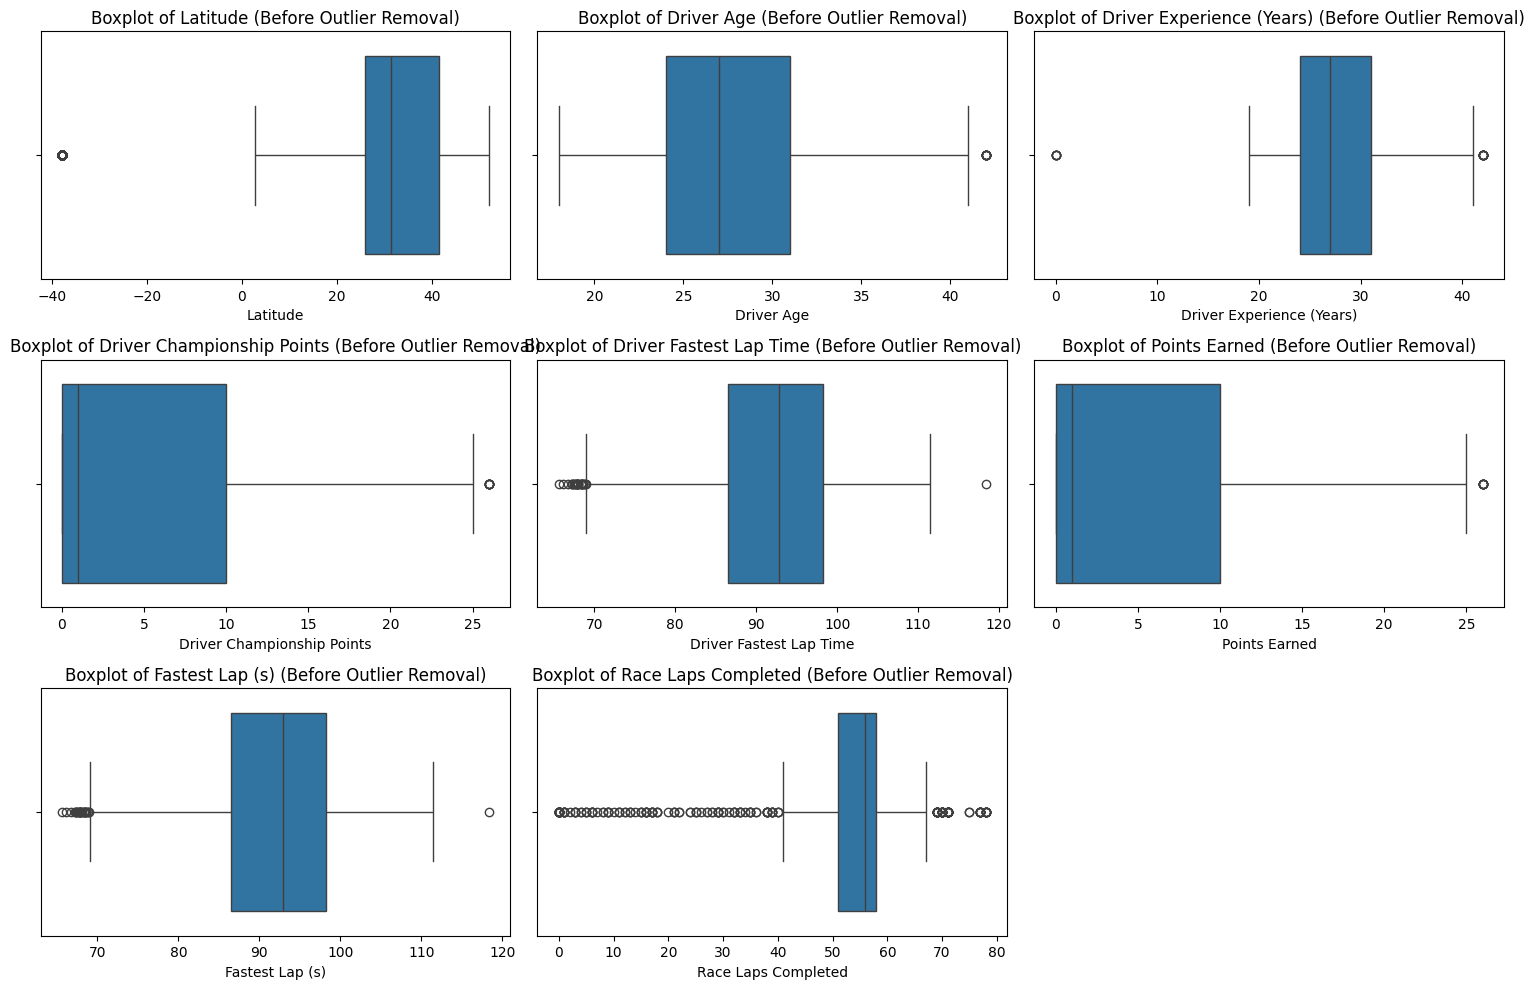

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to detect outliers using IQR
def detect_outliers_iqr(df, columns):
    outlier_counts = {}
    outlier_columns = []  # List to store columns with outliers

    for column in columns:
        Q1 = df[column].quantile(0.25)  # First Quartile (25%)
        Q3 = df[column].quantile(0.75)  # Third Quartile (75%)
        IQR = Q3 - Q1  # Interquartile Range
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_counts[column] = outliers.shape[0]  # Count of outliers

        # Add column to outlier_columns if it has any outliers
        if outliers.shape[0] > 0:
            outlier_columns.append(column)

    return outlier_columns, outlier_counts

# List of numerical columns
numerical_columns = ['Season', 'Round', 'Latitude', 'Longitude', 'Driver Age',
       'Driver Experience (Years)', 'Driver Championship Points', 'Driver Fastest Lap Time',
       'Driver Fastest Lap Rank', 'Grid Position', 'Race Position',
       'Points Earned', 'Fastest Lap (s)', 'Fastest Lap Rank',
       'Total Pit Stops', 'Race Laps Completed']

# Detect outliers in these columns
outlier_columns, iqr_outliers = detect_outliers_iqr(df, numerical_columns)
print("Columns with outliers detected:", outlier_columns)

# Plot boxplots for the columns with outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(outlier_columns, 1):
    plt.subplot(3, 3, i)  # Adjust layout based on number of plots
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col} (Before Outlier Removal)')
plt.tight_layout()
plt.show()


#After removal of Outliers

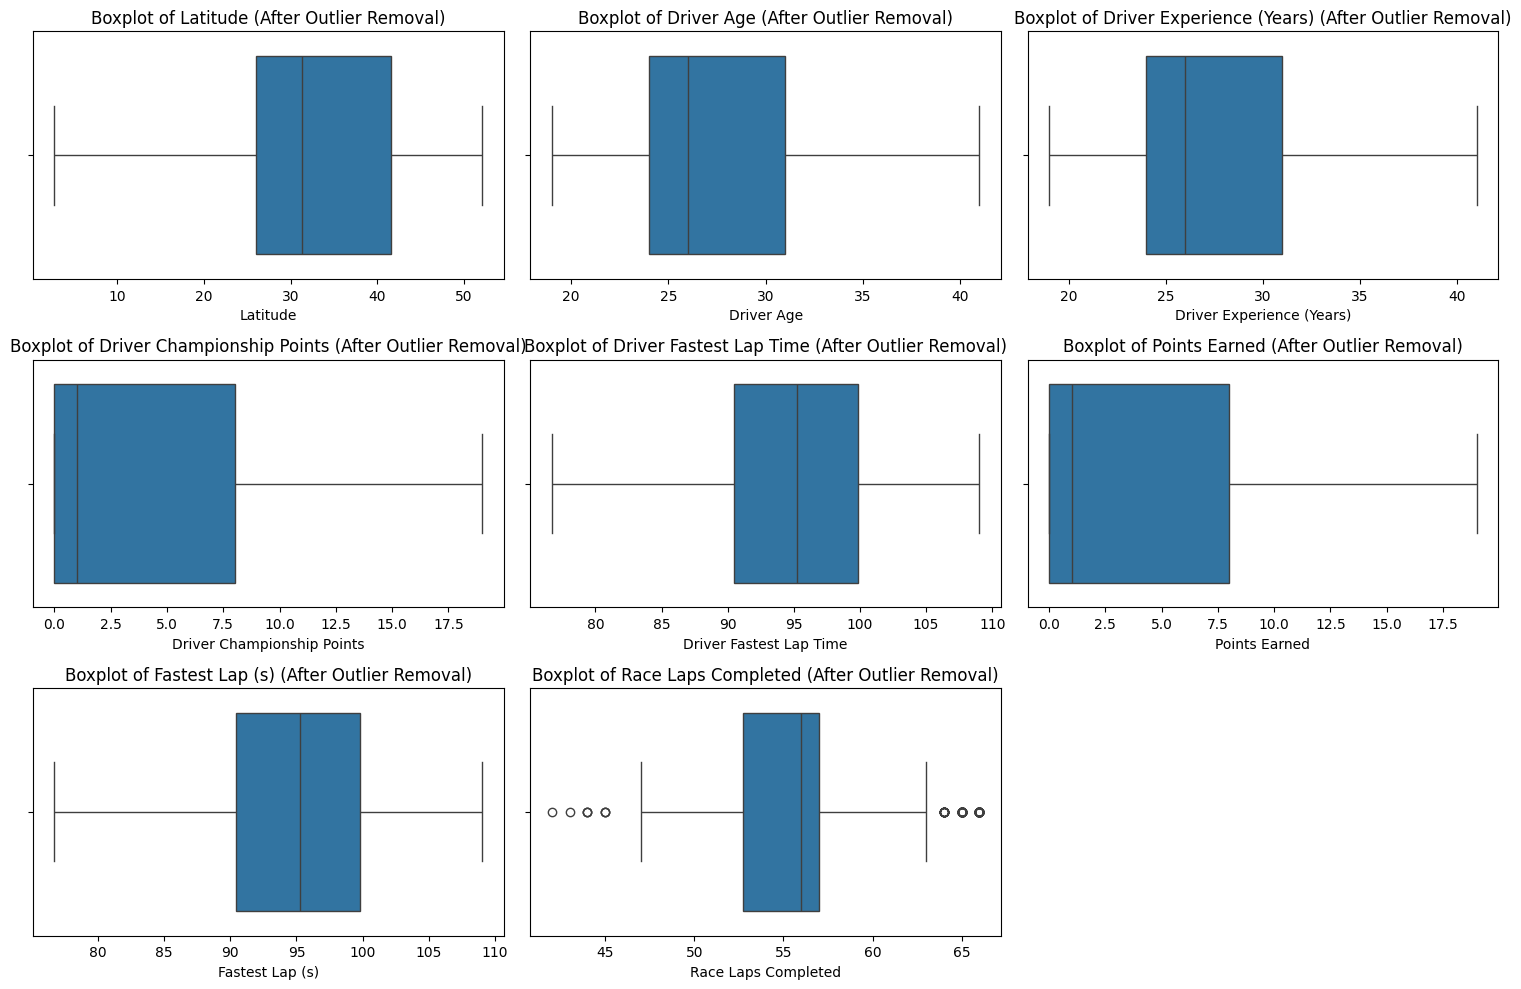

In [20]:
# Function to remove outliers using IQR
def remove_outliers_iqr(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Remove outliers
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df

# Apply the function to remove outliers
df_cleaned = remove_outliers_iqr(df, outlier_columns)

# Plot boxplots after removing outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(outlier_columns, 1):
    plt.subplot(3, 3, i)  # Adjust layout based on number of plots
    sns.boxplot(x=df_cleaned[col])
    plt.title(f'Boxplot of {col} (After Outlier Removal)')
plt.tight_layout()
plt.show()


**Cleaned Dataset after data cleaning**

In [21]:
df_cleaned

,Season,Round,Race Name,Date,Circuit,Country,Latitude,Longitude,Driver,Driver Nationality,...,Constructor,Constructor Nationality,Grid Position,Race Position,Points Earned,Fastest Lap (s),Fastest Lap Rank,Total Pit Stops,Race Laps Completed,Retirement Status
23,2014,2,Malaysian Grand Prix,2014-03-30,Sepang International Circuit,Malaysia,2.76083,101.7380,Nico Rosberg,German,...,Mercedes,German,3,2,18.0,103.960,2,-1,56,Finished
24,2014,2,Malaysian Grand Prix,2014-03-30,Sepang International Circuit,Malaysia,2.76083,101.7380,Sebastian Vettel,German,...,Red Bull,Austrian,2,3,15.0,104.289,4,-1,56,Finished
25,2014,2,Malaysian Grand Prix,2014-03-30,Sepang International Circuit,Malaysia,2.76083,101.7380,Fernando Alonso,Spanish,...,Ferrari,Italian,4,4,12.0,104.165,3,-1,56,Finished
26,2014,2,Malaysian Grand Prix,2014-03-30,Sepang International Circuit,Malaysia,2.76083,101.7380,Nico Hülkenberg,German,...,Force India,Indian,7,5,10.0,105.982,10,-1,56,Finished
27,2014,2,Malaysian Grand Prix,2014-03-30,Sepang International Circuit,Malaysia,2.76083,101.7380,Jenson Button,British,...,McLaren,British,10,6,8.0,106.039,11,-1,56,Finished
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2023,5,Miami Grand Prix,2023-05-07,Miami International Autodrome,USA,25.95810,-80.2389,Guanyu Zhou,Chinese,...,Alfa Romeo,Swiss,14,16,0.0,91.736,14,-1,57,Retired
996,2023,5,Miami Grand Prix,2023-05-07,Miami International Autodrome,USA,25.95810,-80.2389,Lando Norris,British,...,McLaren,British,16,17,0.0,92.401,20,-1,57,Retired
997,2023,5,Miami Grand Prix,2023-05-07,Miami International Autodrome,USA,25.95810,-80.2389,Nyck de Vries,Dutch,...,AlphaTauri,Italian,15,18,0.0,91.562,12,-1,57,Retired
998,2023,5,Miami Grand Prix,2023-05-07,Miami International Autodrome,USA,25.95810,-80.2389,Oscar Piastri,Australian,...,McLaren,British,19,19,0.0,92.006,18,-1,56,Retired


**Saving the cleaned DataFrame as a CSV file**

In [22]:
df_cleaned.to_csv('cleaned_f1_data.csv', index=False)


#VISUALIZATIONS

**Distribution of Driver Age**

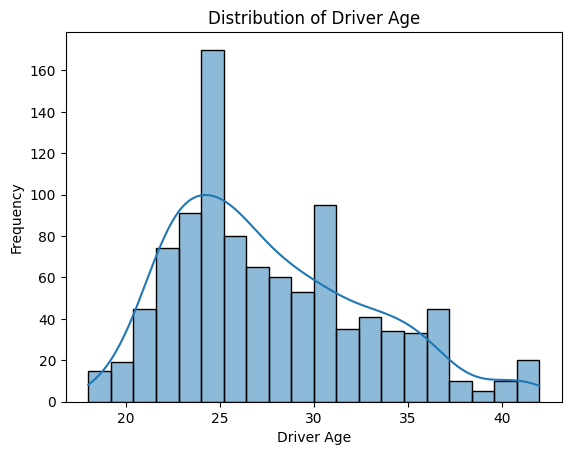

In [23]:
import matplotlib.pyplot as plt
sns.histplot(df['Driver Age'], bins=20, kde=True)
plt.title('Distribution of Driver Age')
plt.xlabel('Driver Age')
plt.ylabel('Frequency')
plt.show()


 **Performance by Driver Nationality**

<ipython-input-24-a662ebaa35f0>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Driver Nationality',


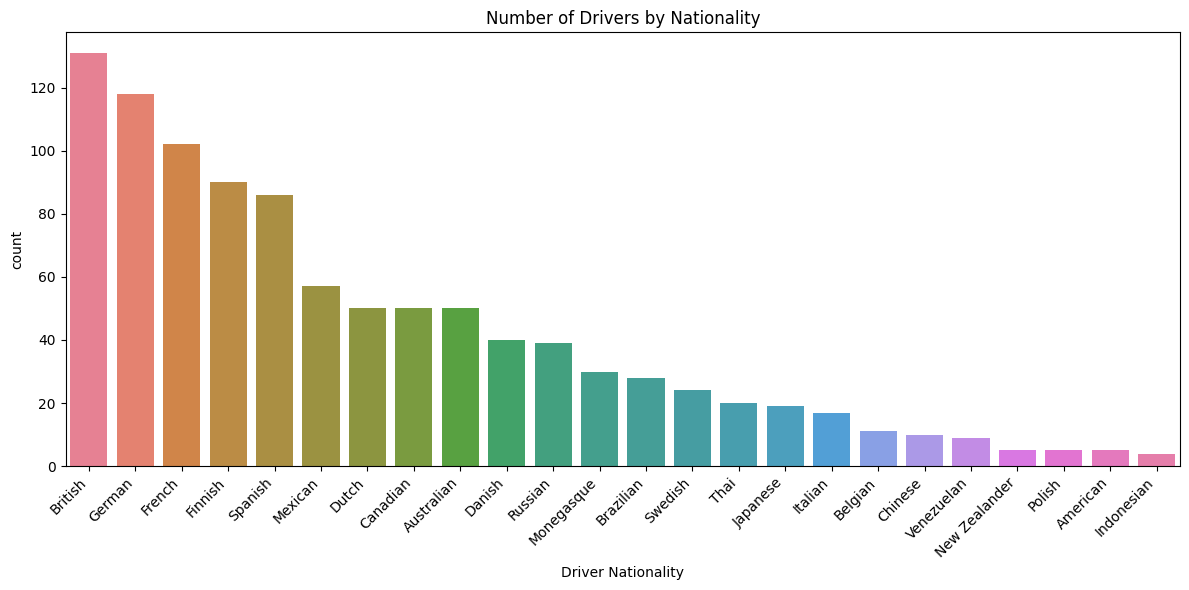

In [24]:
plt.figure(figsize=(12, 6))
# Create color palette with as many colors as there are countries
colors = sns.color_palette("husl", n_colors=len(df['Driver Nationality'].unique()))

# Create the plot
ax = sns.countplot(x='Driver Nationality',
                  data=df,
                  order=df['Driver Nationality'].value_counts().index,
                  palette=colors)

plt.title('Number of Drivers by Nationality')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



**Race Positions Distribution**

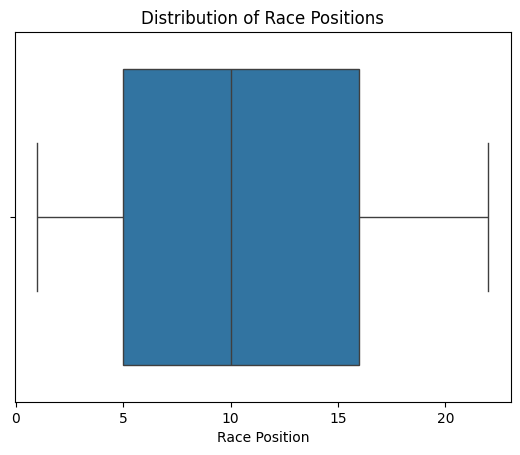

In [25]:
sns.boxplot(x='Race Position', data=df)
plt.title('Distribution of Race Positions')
plt.xlabel('Race Position')
plt.show()


**Scatter Plot: Driver Age vs Championship Points**

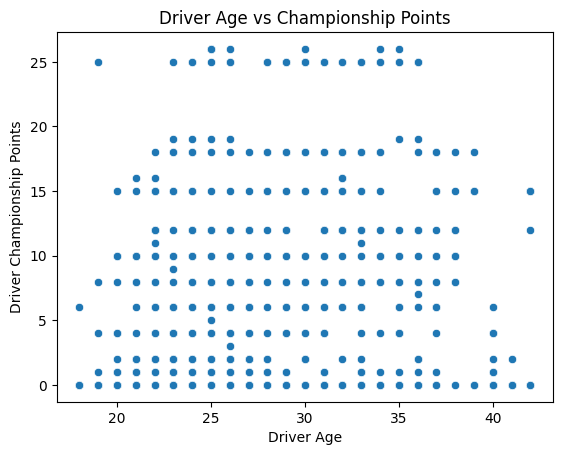

In [26]:
sns.scatterplot(x='Driver Age', y='Driver Championship Points', data=df)
plt.title('Driver Age vs Championship Points')
plt.xlabel('Driver Age')
plt.ylabel('Driver Championship Points')
plt.show()



**Distribution of Race Wins by Constructor**

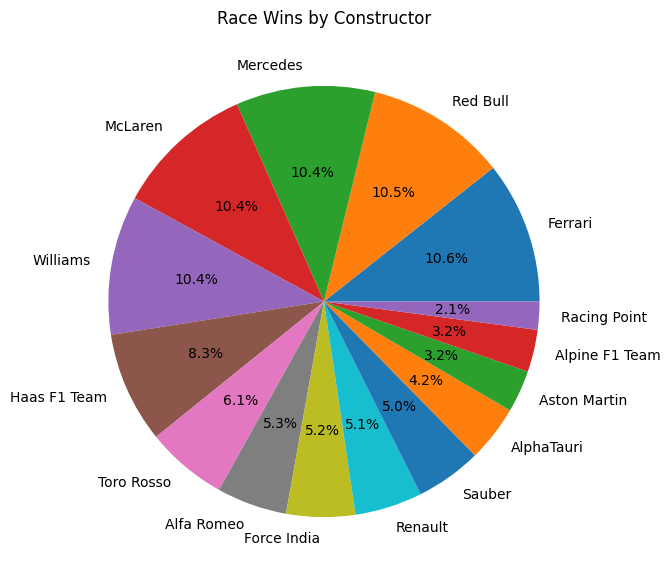

In [27]:
excluded_teams = ["Caterham", "Marussia", "Manor Marussia", "Lotus F1"]
filtered_df = df[~df['Constructor'].isin(excluded_teams)]

# Count values and plot
constructor_wins = filtered_df['Constructor'].value_counts()
constructor_wins.plot.pie(autopct='%1.1f%%', figsize=(7, 7), legend=False)

plt.title('Race Wins by Constructor')
plt.ylabel('')
plt.show()


**Heatmap: Correlation Between Numeric Variables**

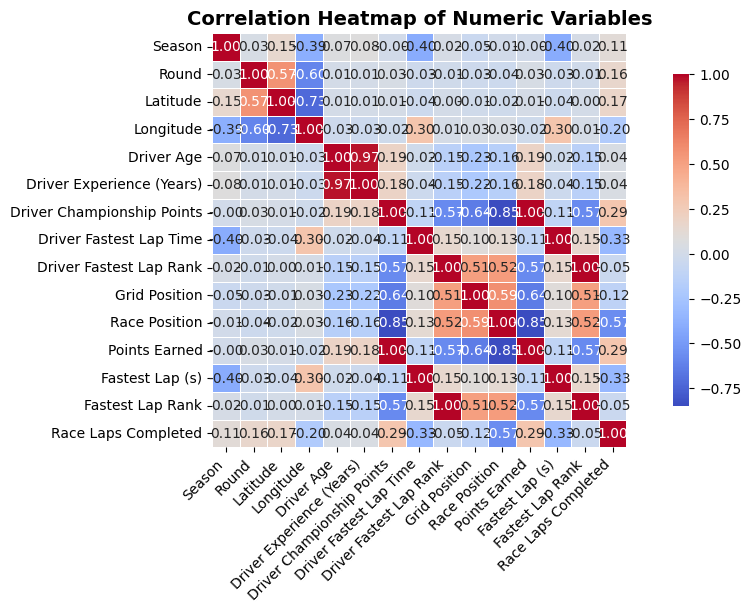

In [28]:
corr_matrix = df[numerical_columns].corr().dropna(how='all', axis=0).dropna(how='all', axis=1)
plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5,
    square=True,
    cbar_kws={'shrink': 0.8}
)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.title('Correlation Heatmap of Numeric Variables', fontsize=14, fontweight='bold')
plt.show()



**Race Laps Completed VS Race Position**

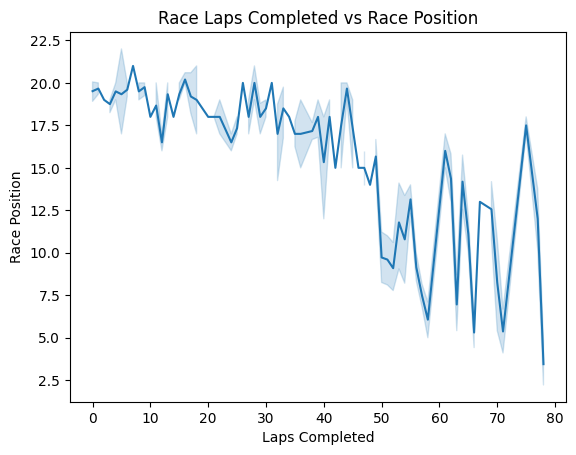

In [29]:
sns.lineplot(x='Race Laps Completed', y='Race Position', data=df)
plt.title('Race Laps Completed vs Race Position')
plt.xlabel('Laps Completed')
plt.ylabel('Race Position')
plt.show()


**Top 5 Drivers Performance Over Time**

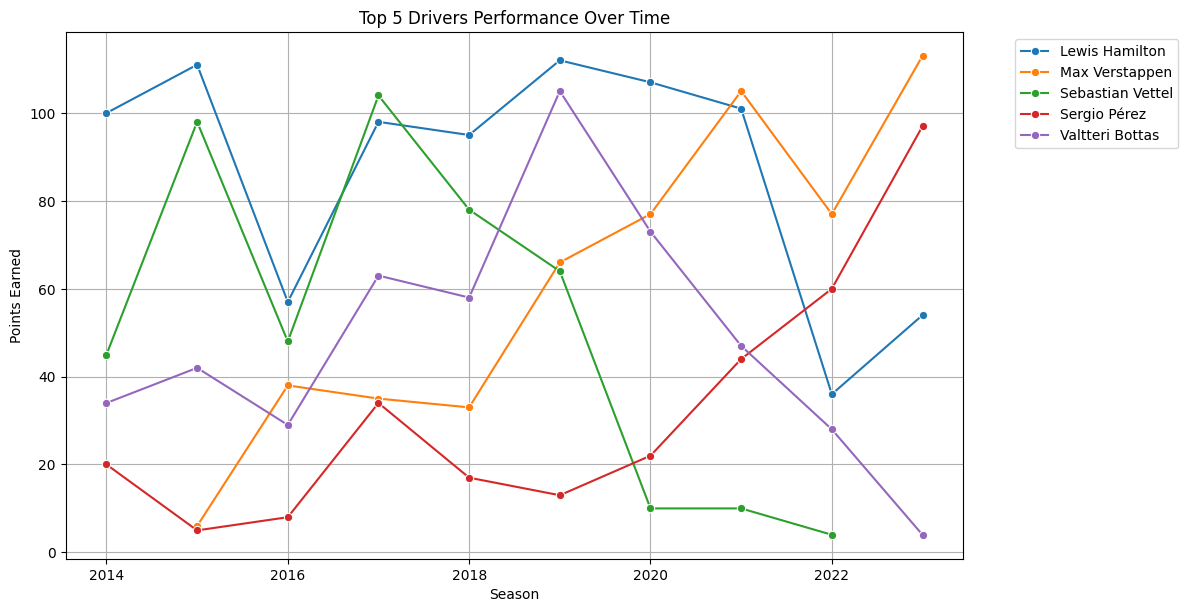

In [30]:
# Group data by driver and year, sum points
driver_yearly_points = df.groupby(['Driver', 'Season'])['Points Earned'].sum().reset_index()

# Get top 5 drivers with the most total points
top_drivers = driver_yearly_points.groupby('Driver')['Points Earned'].sum().sort_values(ascending=False).head(5).index

# Filter data for top drivers
top_drivers_df = driver_yearly_points[driver_yearly_points['Driver'].isin(top_drivers)]

# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=top_drivers_df,
    x='Season',
    y='Points Earned',
    hue='Driver',
    marker='o'
)

# Move legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent legend cutoff
plt.tight_layout()

plt.title('Top 5 Drivers Performance Over Time')
plt.grid(True)

**Fastest lap Time Distribution by Constructor**

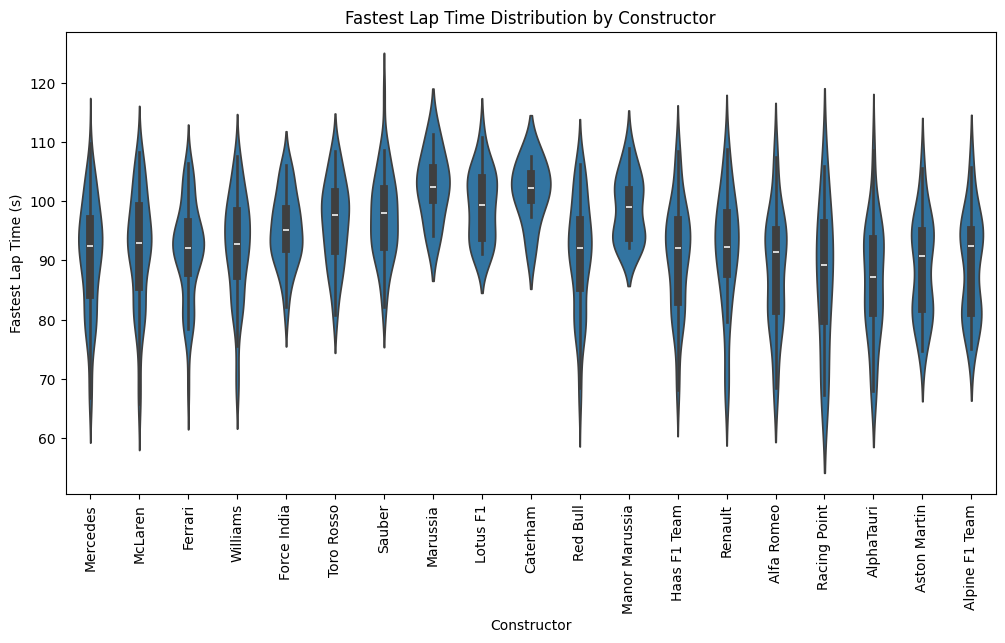

In [31]:
plt.figure(figsize=(12, 6))
sns.violinplot(x=df["Constructor"], y=df["Fastest Lap (s)"])
plt.xticks(rotation=90)
plt.title("Fastest Lap Time Distribution by Constructor")
plt.xlabel("Constructor")
plt.ylabel("Fastest Lap Time (s)")
plt.show()


**Average Grid osition by Driver nationality**

<ipython-input-32-8131d7c66f71>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_grid_position.index, y=average_grid_position.values, palette="coolwarm")


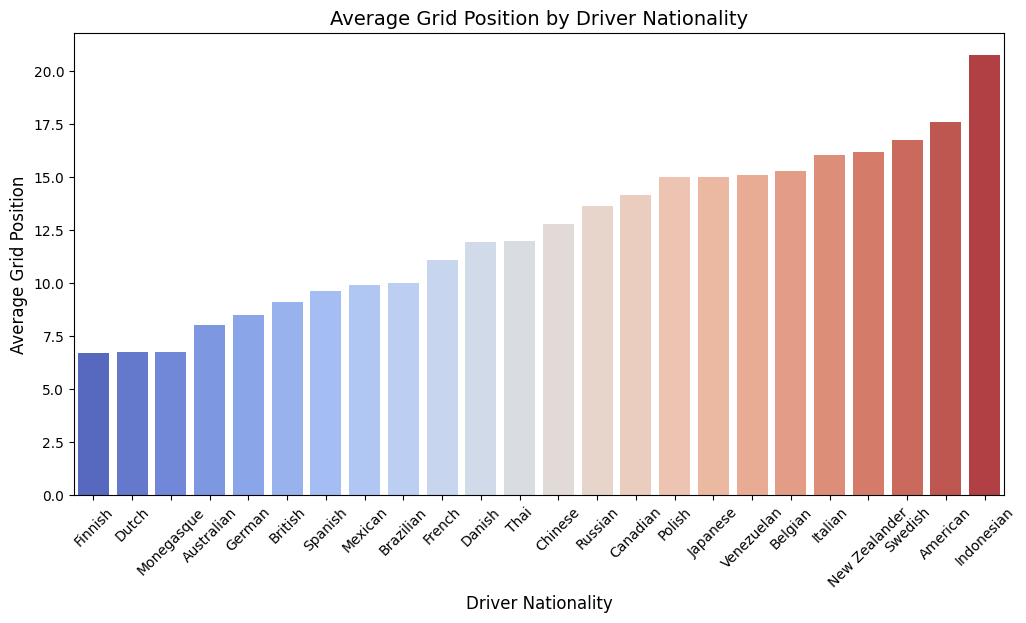

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate average Grid Position by Driver Nationality
average_grid_position = df.groupby("Driver Nationality")["Grid Position"].mean().sort_values(ascending=True)

# Set figure size
plt.figure(figsize=(12, 6))

# Create the bar chart for average Grid Position by Driver Nationality
sns.barplot(x=average_grid_position.index, y=average_grid_position.values, palette="coolwarm")

# Titles and labels
plt.title("Average Grid Position by Driver Nationality", fontsize=14)
plt.xlabel("Driver Nationality", fontsize=12)
plt.ylabel("Average Grid Position", fontsize=12)

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()
